해파리 이미지는 각 종류마다 색깔이 다른데
히스토그램을 사용하면 이러한 해파리 이미지 데이터를 분석하기에 좋지 않을까..?

상관관계 (Correlation)
두 이미지가 가진 전체적인 색상 패턴을 비교
두 해파리가 비슷한 색상을 전체적으로 가지고 있다면 상관관계 값이 높게 나옴

교차 (Intersection)
두 히스토그램에서 겹치는 영역만 계산
교차 방식은 두 히스토그램의 공통 부분만을 측정하므로 특정 색상의 유사성을 확인하는 데 좋음

히스토그램은 이미지의 픽셀 값 분포만을 고려하므로 해파리 모양과 같은 구조적 특성 반영하지 못함

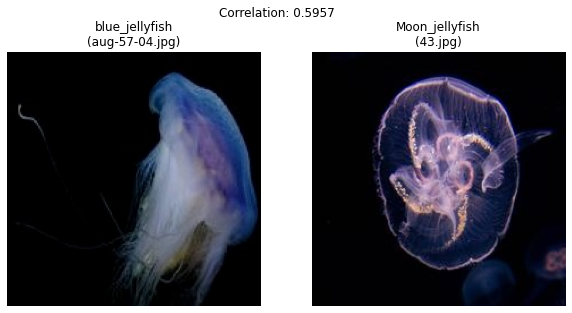

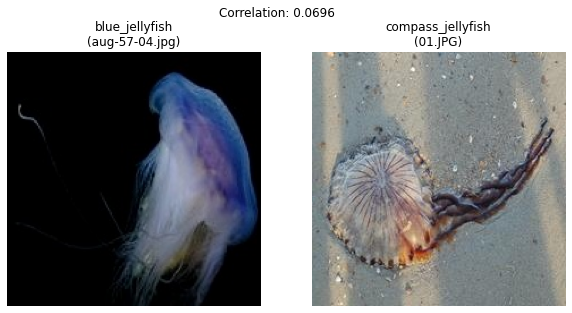

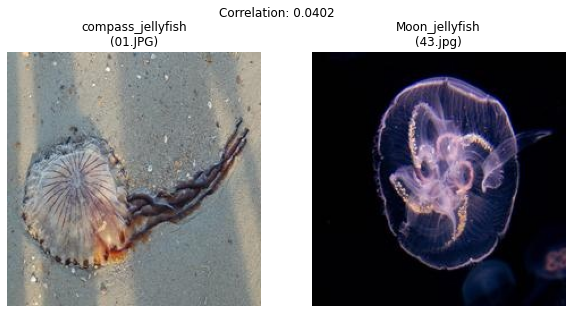

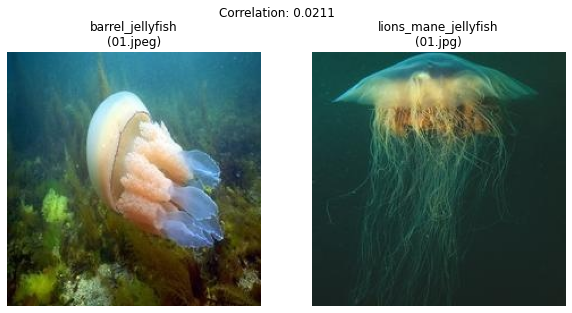

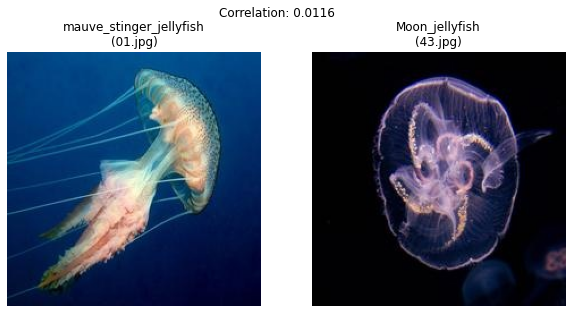

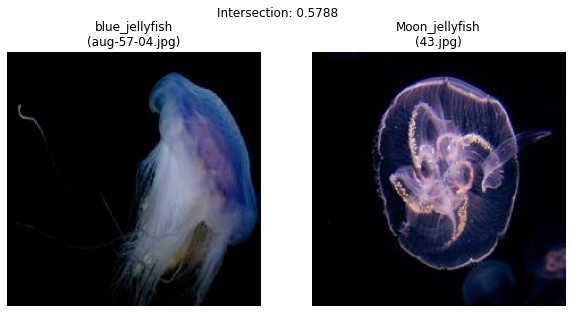

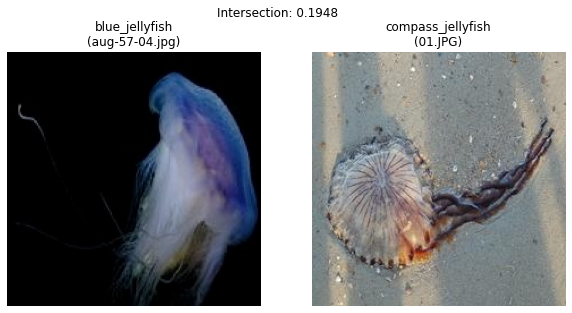

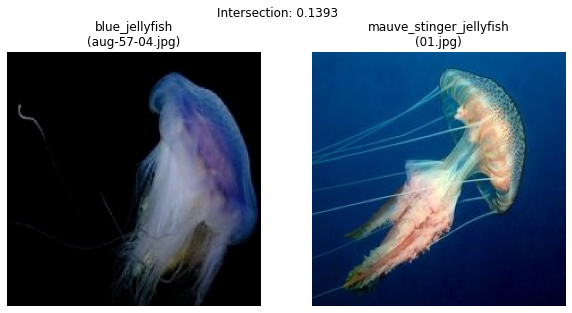

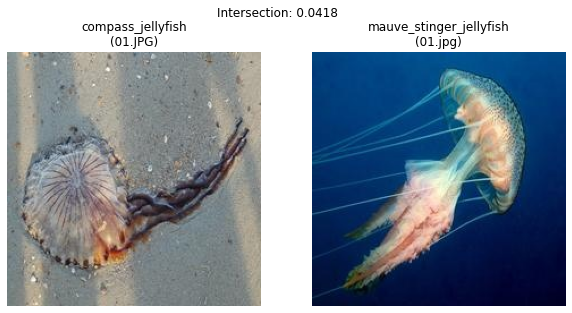

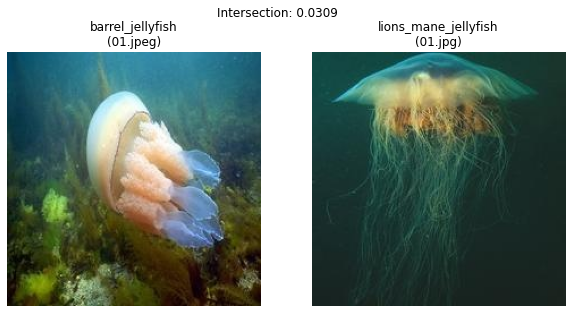

In [53]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path

def load_image_per_class(dataset_path, classes, image_indices=None):
    class_images = {}
    class_hists = {}
    class_image_paths = {}

    for i, cls in enumerate(classes):
        class_dir = os.path.join(dataset_path, cls)
        if not os.path.exists(class_dir):
            print(f"경고: {class_dir} 디렉토리가 존재하지 않습니다.")
            continue

        images = sorted(os.listdir(class_dir))
        if not images:
            print(f"경고: {class_dir}에 이미지가 없습니다.")
            continue

        # 특정 인덱스의 이미지를 선택 (기본값: 첫 번째 이미지)
        idx = image_indices[i] if image_indices and i < len(image_indices) else 0
        img_name = images[idx]
        img_path = os.path.join(class_dir, img_name)

        img = cv2.imread(img_path)
        if img is None:
            print(f"경고: {img_path} 이미지를 로드할 수 없습니다.")
            continue

        # 히스토그램 계산 (HSV 색상 공간)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
        cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)

        # 클래스별로 이미지 저장
        class_images[cls] = img
        class_hists[cls] = hist
        class_image_paths[cls] = img_path

    return class_hists, class_images, class_image_paths

def calculate_similarity_single_image(class_hists, classes):
    """클래스 간 하나의 이미지씩 비교"""
    methods = [cv2.HISTCMP_CORREL, cv2.HISTCMP_INTERSECT] # 비교 방법 목록
    method_names = ['Correlation', 'Intersection']
    similarity_results = {method: [] for method in method_names}

    # 클래스 쌍 생성
    class_pairs = [(classes[i], classes[j]) for i in range(len(classes)) for j in range(i + 1, len(classes))]

    for i, method in enumerate(methods):
        for cls1, cls2 in class_pairs:
            hist1 = class_hists[cls1]
            hist2 = class_hists[cls2]
            
            # 두 히스토그램 간 유사도 계산
            ret = cv2.compareHist(hist1, hist2, method)
            if method == cv2.HISTCMP_INTERSECT:
                ret /= np.sum(hist1)  # 교차 방식 정규화
            
            similarity_results[method_names[i]].append((cls1, cls2, ret))

    return similarity_results

def visualize_comparisons(similarity_results, class_images, class_image_paths):
    """클래스 간 비교 결과 시각화"""
    for method_name in ['Correlation', 'Intersection']:
        results = similarity_results[method_name]
        
        # 유사도 상위 5쌍 추출
        reverse_sort = True  # 값이 클수록 유사
        sorted_results = sorted(results, key=lambda x: x[2], reverse=reverse_sort)[:5]

        for cls1, cls2, score in sorted_results:
            img1_path = class_image_paths[cls1]
            img2_path = class_image_paths[cls2]
            
            plt.figure(figsize=(10, 5))
            
            # 첫 번째 이미지 표시
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(class_images[cls1], cv2.COLOR_BGR2RGB))
            plt.title(f"{cls1}\n({os.path.basename(img1_path)})")
            plt.axis('off')
            
            # 두 번째 이미지 표시
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(class_images[cls2], cv2.COLOR_BGR2RGB))
            plt.title(f"{cls2}\n({os.path.basename(img2_path)})")
            plt.axis('off')
            
            plt.suptitle(f"{method_name}: {score:.4f}")
            plt.show()

def main():
    dataset_path = Path.home() / 'aiffel/jellyfish/Train_Test_Valid/Train'
    
    classes = [
        "barrel_jellyfish",
        "blue_jellyfish", 
        "compass_jellyfish",
        "lions_mane_jellyfish",
        "mauve_stinger_jellyfish",
        "Moon_jellyfish"
    ]
    
    # 각 클래스에서 사용할 이미지의 인덱스 지정 
    image_indices = [0, 108, 0, 0, 0, 32]  # 각 클래스의 이미지 인덱스
    
    # 각 클래스에서 지정된 인덱스의 이미지 로드 및 히스토그램 계산
    class_hists, class_images, class_image_paths = load_image_per_class(dataset_path, classes, image_indices)
    
    # 유사도 계산 (클래스당 하나의 이미지 사용)
    similarity_results = calculate_similarity_single_image(class_hists, classes)
    
    # 시각화 (상위 유사도 쌍 표시)
    visualize_comparisons(similarity_results, class_images, class_image_paths)

if __name__ == "__main__":
    main()
